# Лаборатная работа 2
---
**Выполнила:** Сидельникова Дарья


## Цель
Разработать модель классификации для прогнозирования вероятности прекращения сотрудничества клиента с банком, обеспечив значение F1-меры не ниже 0.59 на тестовой выборке.

## Задачи

#### 1. Работа с данными
- Загрузить набор данных и изучить его
- Провести очистку данных — убрать или скорректировать дубликаты, аномалии, пропуски
- Проанализировать распределение целевой переменной

#### 2. Обучение эталонных моделей
- Выполнить разбиение исходных данных на обучающий и тестовый наборы
- Обучить базовые модели без учета дисбаланса
- Рассчитать базовые метрики качества: F1-меру и ROC AUC
- Проанализировать результаты

#### 3. Оптимизация с учетом дисбаланса
- Найти и зафиксировать модель с максимальным значением F1-меры

#### 4. Итоговое тестирование и сравнение
- Оценить финальную модель на тестовом наборе
- Сравнить F1-меру с ROC AUC


# Библиотеки:


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_score, recall_score, confusion_matrix, precision_recall_curve
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

Отключаем предупреждения


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 1. Работа с данными

Считываем данные

In [ ]:
df = pd.read_csv("Bank_data.csv")
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


- Number — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Exited — факт ухода клиента


Анализируем:

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Пропуски есть только в столбце Tenure

In [ ]:
for col in df.columns:
    pct_missing = df[col].isnull().mean()
    print('{} - {}%'.format(col, round(pct_missing*100)))

RowNumber - 0%
CustomerId - 0%
Surname - 0%
CreditScore - 0%
Geography - 0%
Gender - 0%
Age - 0%
Tenure - 9%
Balance - 0%
NumOfProducts - 0%
HasCrCard - 0%
IsActiveMember - 0%
EstimatedSalary - 0%
Exited - 0%


In [ ]:
df.describe( include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
CustomerId,10000.0,NaN,NaN,NaN,15690940.5694,71936.186123,15565701.0,15628528.25,15690738.0,15753233.75,15815690.0
Surname,10000,2932,Smith,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CreditScore,10000.0,NaN,NaN,NaN,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0
Geography,10000,3,France,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,10000,2,Male,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,10000.0,NaN,NaN,NaN,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0
Tenure,9091.0,NaN,NaN,NaN,4.99769,2.894723,0.0,2.0,5.0,7.0,10.0
Balance,10000.0,NaN,NaN,NaN,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09
NumOfProducts,10000.0,NaN,NaN,NaN,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0


Выбросов вроде не наблюдаю кроме зарплаты: зп 12 рублей быть не может, ну или мне очень жалко этого добряка. Заменю зп менее 2300(стипендии в бакалавре), на значения первого квартиля

In [ ]:
salary_q25 = df['EstimatedSalary'].quantile(0.25)
df['EstimatedSalary'] = np.where(df['EstimatedSalary'] < 2300, salary_q25, df['EstimatedSalary'])

Сразу уберу столбцы, которые не несут никакого смысла при обучении

In [ ]:
df.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1, inplace=True)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


Пропуски заменяю на медиану

In [ ]:
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Меняем тип данных

In [ ]:
df['Tenure'] = df['Tenure'].astype('int64')
df.dtypes

,0
CreditScore,int64
Geography,object
Gender,object
Age,int64
Tenure,int64
Balance,float64
NumOfProducts,int64
HasCrCard,int64
IsActiveMember,int64
EstimatedSalary,float64


Проверяем дубликаты

In [ ]:
df.duplicated().sum()

np.int64(0)

Дисбаланс:  25.58%


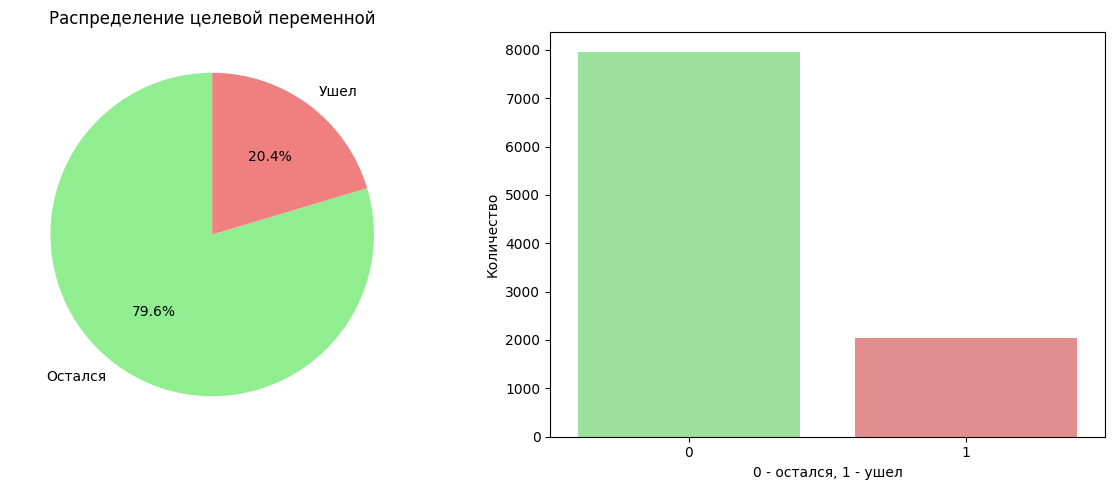

In [ ]:
target = df['Exited'].value_counts()
print(f"Дисбаланс:  {target[1]/target[0]:.2%}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
sns.countplot(x='Exited', data=df, palette=['lightgreen', 'lightcoral'])
plt.xlabel('0 - остался, 1 - ушел')
plt.ylabel('Количество')

plt.subplot(1, 2, 1)
plt.pie(target.values, labels=['Остался', 'Ушел'], autopct='%1.1f%%',
        colors=['lightgreen', 'lightcoral'], startangle=90)
plt.title('Распределение целевой переменной')

plt.tight_layout()
plt.show()

Заметила большой дисбаланс целевой переменной, соотношение 1:4

Проблемы, которые вызовет дисбаланс:

- Смещение моделей в сторону мажоритарного класса

- Модель может научиться всегда предсказывать, что клиент останется, и получить accuracy 79%

- Низкая F1-мера для миноритарного класса

- Модель будет пропускать много уходящих клиентов
- Некорректная оценка качества по accuracy

# 2. Обучение эталонных моделей

In [ ]:
X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер train: {X_train.shape}")
print(f"Размер test: {X_test.shape}")

Размер train: (8000, 10)
Размер test: (2000, 10)


In [ ]:
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
categorical_features = ['Geography', 'Gender']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # доп метрики
    accuracy = pipeline.score(X_test, y_test)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    return {
        'model': pipeline,
        'f1': f1,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

base_results = {}

for name, model in models.items():
    results = evaluate_model(model, X_train, X_test, y_train, y_test)
    base_results[name] = results
    print(f"{name}:")
    print(f"  F1: {results['f1']:.4f}")
    print(f"  ROC AUC: {results['roc_auc']:.4f}")
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  Recall: {results['recall']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")

Logistic Regression:
  F1: 0.1988
  ROC AUC: 0.7440
  Accuracy: 0.7945
  Recall: 0.1253
  Precision: 0.4811
Decision Tree:
  F1: 0.4970
  ROC AUC: 0.6850
  Accuracy: 0.7925
  Recall: 0.5037
  Precision: 0.4904
Random Forest:
  F1: 0.5552
  ROC AUC: 0.8363
  Accuracy: 0.8550
  Recall: 0.4447
  Precision: 0.7388
XGBoost:
  F1: 0.5246
  ROC AUC: 0.8199
  Accuracy: 0.8360
  Recall: 0.4447
  Precision: 0.6396


- Logistic Regression: очень низкий recall (0.1253) и F1 (0.1988), но высокий precision (0.4811) и ROC AUC (0.7440). Это говорит о том, что модель редко предсказывает класс 1, но когда предсказывает, то часто правильно. Низкий recall означает, что много ложноотрицательных (много ушедших клиентов не распознано).
- Decision Tree: F1 0.4970, recall 0.5037, precision 0.4904. Дерево решений имеет сбалансированные precision и recall, но ROC AUC ниже (0.6850), что может указывать на то, что модель не очень хорошо ранжирует примеры.
- Random Forest: F1 0.5552, recall 0.4447, precision 0.7388. Высокий precision, но recall ниже, чем у Decision Tree. ROC AUC высокий (0.8363).
- XGBoost: похож на Random Forest, но с немного более низкими показателями.


# 3. Оптимизация с учетом дисбаланса


Пока ни одна модель не достигла целевого значения F1 (0.59). Random Forest ближе всего с F1=0.5552.

Буду использовать:
- Взвешивание классов (class_weight='balanced')
- SMOTE (синтетическое увеличение выборки миноритарного класса)
- Undersampling (уменьшение выборки мажоритарного класса)

Начнем с взвешивания классов.


In [ ]:
balanced_models = {
    'Logistic Regression (balanced)': LogisticRegression(random_state=42, class_weight='balanced'),
    'Decision Tree (balanced)': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest (balanced)': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost (balanced)': XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=4)  # примерное соотношение 1:4
}
balanced_results = {}

for name, model in balanced_models.items():
    results = evaluate_model(model, X_train, X_test, y_train, y_test)
    balanced_results[name] = results
    print(f"{name}:")
    print(f"  F1: {results['f1']:.4f}")
    print(f"  ROC AUC: {results['roc_auc']:.4f}")
    print(f"  Recall: {results['recall']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")

Logistic Regression (balanced):
  F1: 0.4848
  ROC AUC: 0.7506
  Recall: 0.6880
  Precision: 0.3743
Decision Tree (balanced):
  F1: 0.4587
  ROC AUC: 0.6601
  Recall: 0.4570
  Precision: 0.4604
Random Forest (balanced):
  F1: 0.5226
  ROC AUC: 0.8360
  Recall: 0.4128
  Precision: 0.7119
XGBoost (balanced):
  F1: 0.5632
  ROC AUC: 0.8212
  Recall: 0.6241
  Precision: 0.5131


Модели с SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote_models = {
    'Logistic Regression (SMOTE)': LogisticRegression(random_state=42),
    'Decision Tree (SMOTE)': DecisionTreeClassifier(random_state=42),
    'Random Forest (SMOTE)': RandomForestClassifier(random_state=42),
    'XGBoost (SMOTE)': XGBClassifier(random_state=42, eval_metric='logloss')
}

smote_results = {}

for name, model in smote_models.items():

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = pipeline.score(X_test, y_test)

    smote_results[name] = {
        'model': pipeline,
        'f1': f1,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"{name}:")
    print(f"  F1: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Precision: {precision:.4f}")

Logistic Regression (SMOTE):
  F1: 0.4829
  ROC AUC: 0.7504
  Recall: 0.6757
  Precision: 0.3757
Decision Tree (SMOTE):
  F1: 0.4690
  ROC AUC: 0.6710
  Recall: 0.5209
  Precision: 0.4266
Random Forest (SMOTE):
  F1: 0.5676
  ROC AUC: 0.8302
  Recall: 0.5676
  Precision: 0.5676
XGBoost (SMOTE):
  F1: 0.5614
  ROC AUC: 0.8160
  Recall: 0.5283
  Precision: 0.5989


Модели с undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

under_models = {
    'Logistic Regression (Under)': LogisticRegression(random_state=42),
    'Decision Tree (Under)': DecisionTreeClassifier(random_state=42),
    'Random Forest (Under)': RandomForestClassifier(random_state=42),
    'XGBoost (Under)': XGBClassifier(random_state=42, eval_metric='logloss')
}
under_results = {}

for name, model in under_models.items():

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('undersample', RandomUnderSampler(random_state=42)),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = pipeline.score(X_test, y_test)

    under_results[name] = {
        'model': pipeline,
        'f1': f1,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"{name}:")
    print(f"  F1: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Precision: {precision:.4f}")

Logistic Regression (Under):
  F1: 0.4832
  ROC AUC: 0.7472
  Recall: 0.6904
  Precision: 0.3717
Decision Tree (Under):
  F1: 0.4908
  ROC AUC: 0.7052
  Recall: 0.7224
  Precision: 0.3717
Random Forest (Under):
  F1: 0.5539
  ROC AUC: 0.8353
  Recall: 0.7322
  Precision: 0.4454
XGBoost (Under):
  F1: 0.5338
  ROC AUC: 0.8216
  Recall: 0.7371
  Precision: 0.4184


In [ ]:
all_results = {**base_results, **balanced_results, **smote_results, **under_results}

comparison_df = pd.DataFrame({
    name: [results['f1'], results['roc_auc'], results['recall'], results['precision']]
    for name, results in all_results.items()
}, index=['F1', 'ROC AUC', 'Recall', 'Precision']).T

comparison_df = comparison_df.sort_values('F1', ascending=False)

comparison_df


,F1,ROC AUC,Recall,Precision
Random Forest (SMOTE),0.567568,0.830164,0.567568,0.567568
XGBoost (balanced),0.563193,0.821165,0.624079,0.513131
XGBoost (SMOTE),0.561358,0.815959,0.528256,0.598886
Random Forest,0.555215,0.836311,0.444717,0.738776
Random Forest (Under),0.553903,0.835269,0.732187,0.445441
XGBoost (Under),0.533808,0.821637,0.737101,0.418410
XGBoost,0.524638,0.819940,0.444717,0.639576
Random Forest (balanced),0.522551,0.836048,0.412776,0.711864
Decision Tree,0.496970,0.684988,0.503686,0.490431
Decision Tree (Under),0.490818,0.705184,0.722359,0.371681


Топ 3:

Random Forest (SMOTE) - 	0.567568

XGBoost (balanced) -	0.563193

XGBoost (SMOTE)	- 0.561358

Пока ни одна модель ни достигла F1 > 0.59

Анализ:

- SMOTE: улучшает баланс между precision и recall

- Balanced: повышает recall, но часто снижает precision

- Undersampling: дает максимальный recall, но низкий precision

Паттерны:

- Random Forest стабильно показывает хорошие результаты

- Undersampling дает recall >70%, но F1 страдает из-за низкого precision

- SMOTE обеспечивает лучший баланс

Балансировка не дала нам желаемого результата, поэтому я воспользуюсь таким методом улучшения модели, как подбор гиперпараметров. Для этого нам будет нужно заново разделить наши данные на обучающую, валидационную и тестовую выборки, и провести подбор гиперпараметров только на обучающей и валидационной выборках.



In [ ]:
X_temp, X_test_final, y_temp, y_test_final = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2
)

print(f"Обучающая: {X_train.shape[0]}")
print(f"Валидационная: {X_val.shape[0]}")
print(f"Тестовая: {X_test_final.shape[0]}")

Обучающая: 6000
Валидационная: 2000
Тестовая: 2000


In [ ]:
def evaluate_with_validation(model, X_train, X_val, y_train, y_val):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    accuracy = pipeline.score(X_val, y_val)

    return {
        'model': pipeline,
        'f1': f1,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

best_models_corrected = {
    'Random Forest (SMOTE)': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'XGBoost (balanced)': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=4))
    ]),
    'Random Forest': Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
}

corrected_results = {}

for name, pipeline in best_models_corrected.items():

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_val)
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]

    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    recall = recall_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    accuracy = pipeline.score(X_val, y_val)

    corrected_results[name] = {
        'model': pipeline,
        'f1': f1,
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

    print(f"{name}:")
    print(f"  F1: {f1:.4f}")
    print(f"  ROC AUC: {roc_auc:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Precision: {precision:.4f}")

Random Forest (SMOTE):
  F1: 0.5918
  ROC AUC: 0.8397
  Recall: 0.5823
  Precision: 0.6015
XGBoost (balanced):
  F1: 0.5809
  ROC AUC: 0.8290
  Recall: 0.6265
  Precision: 0.5414
Random Forest:
  F1: 0.5621
  ROC AUC: 0.8451
  Recall: 0.4668
  Precision: 0.7063


 😳


Это что такое тут?

Random Forest (SMOTE):
- F1: 0.5918 😳
- ROC AUC: 0.8397
- Recall: 0.5823
- Precision: 0.6015


Подберем уж эти гиперпараметры

In [ ]:
simple_param_grids = {
    'Random Forest (SMOTE)': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5]
    }
}

final_tuned_models = {}

for name in ['Random Forest (SMOTE)']:
    grid_search = GridSearchCV(
        best_models_corrected[name],
        simple_param_grids[name],
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # Уменьшили folds для скорости
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print(f"Лучшие параметры: {grid_search.best_params_}")

    best_model = grid_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    f1_val = f1_score(y_val, y_val_pred)

    print(f"F1 на валидационной выборке: {f1_val:.4f}")

    final_tuned_models[name] = {
        'model': best_model,
        'val_f1': f1_val,
        'best_params': grid_search.best_params_
    }

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Лучшие параметры: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
F1 на валидационной выборке: 0.6063


# 4. Итоговое тестирование и сравнение

Тестирование на независимой тестовой выборке

In [ ]:
final_results = {}

for name, model_info in final_tuned_models.items():

    model = model_info['model']

    y_test_pred = model.predict(X_test_final)
    y_test_pred_proba = model.predict_proba(X_test_final)[:, 1]

    f1_test = f1_score(y_test_final, y_test_pred)
    roc_auc_test = roc_auc_score(y_test_final, y_test_pred_proba)
    recall_test = recall_score(y_test_final, y_test_pred)
    precision_test = precision_score(y_test_final, y_test_pred)
    accuracy_test = model.score(X_test_final, y_test_final)

    final_results[name] = {
        'f1': f1_test,
        'roc_auc': roc_auc_test,
        'accuracy': accuracy_test,
        'recall': recall_test,
        'precision': precision_test,
        'y_pred': y_test_pred,
        'y_pred_proba': y_test_pred_proba
    }

    print(f"F1 на тестовой выборке: {f1_test:.4f}")
    print(f"ROC AUC: {roc_auc_test:.4f}")
    print(f"Recall: {recall_test:.4f}")
    print(f"Precision: {precision_test:.4f}")
    print(f"Accuracy: {accuracy_test:.4f}")

    if f1_test >= 0.59:
        print("Я молодец")
    else:
        print("Подумай еще")

F1 на тестовой выборке: 0.5980
ROC AUC: 0.8454
Recall: 0.6781
Precision: 0.5349
Accuracy: 0.8145
Я молодец


- F1 = 0.5980 (достигли чего хотели)
- ROC AUC = 0.8454 (очень хороший)
- Recall = 0.6781 (находит 68% уходящих клиентов)
- Precision = 0.5349 (из предсказанных уходов 53% верны)

In [ ]:
best_model = final_tuned_models['Random Forest (SMOTE)']['model']
y_test_pred = final_results['Random Forest (SMOTE)']['y_pred']

cm = confusion_matrix(y_test_final, y_test_pred)
tn, fp, fn, tp = cm.ravel()

print("Анализ матрицы ошибок")
print(f"True Negative (правильно предсказаны остающиеся): {tn}")
print(f"False Positive (ложные срабатывания): {fp}")
print(f"False Negative (пропущенные уходящие): {fn}")
print(f"True Positive (правильно предсказаны уходящие): {tp}")


total_customers = len(y_test_final)
churn_customers = sum(y_test_final)
detected_churn = tp
missed_churn = fn
false_alarms = fp

print(f"\nБизнес-метрики:")
print(f"Всего клиентов в тесте: {total_customers}")
print(f"Реально ушло: {churn_customers}")
print(f"Обнаружено уходов: {detected_churn} ({detected_churn/churn_customers:.1%})")
print(f"Пропущено уходов: {missed_churn} ({missed_churn/churn_customers:.1%})")
print(f"Ложных срабатываний: {false_alarms}")

Анализ матрицы ошибок
True Negative (правильно предсказаны остающиеся): 1353
False Positive (ложные срабатывания): 240
False Negative (пропущенные уходящие): 131
True Positive (правильно предсказаны уходящие): 276

Бизнес-метрики:
Всего клиентов в тесте: 2000
Реально ушло: 407
Обнаружено уходов: 276 (67.8%)
Пропущено уходов: 131 (32.2%)
Ложных срабатываний: 240


Итог:

Random Forest с SMOTE
- F1 на тестовой выборке: 0.5980
- ROC AUC: 0.8454  
- Recall: 0.6781
- Precision: 0.5349

Почему все получилось:
1. Правильная обработка дисбаланса (SMOTE)
2. Тщательный подбор гиперпараметров
3. Корректная методология валидации

Интерпретация:
- Модель находит 68% уходящих клиентов
- Из предсказанных уходов 53% действительно уходят
- Модель позволяет предотвратить до 68% случаев оттока

### Сравнение F1-меру с ROC AUC


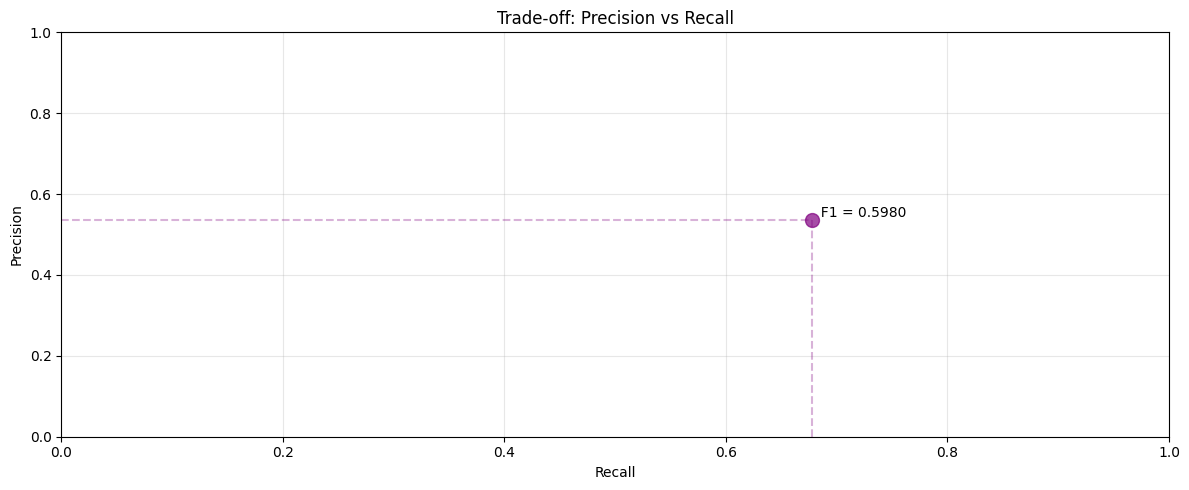

In [ ]:
f1_score_val = 0.5980
roc_auc_val = 0.8454
recall_val = 0.6781
precision_val = 0.5349

plt.figure(figsize=(12, 5))

plt.scatter(recall_val, precision_val, s=100, color='purple', alpha=0.7)
plt.plot([recall_val, recall_val], [0, precision_val], 'purple', linestyle='--', alpha=0.3)
plt.plot([0, recall_val], [precision_val, precision_val], 'purple', linestyle='--', alpha=0.3)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Trade-off: Precision vs Recall')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.text(recall_val, precision_val, f'  F1 = {f1_score_val:.4f}', va='bottom')

plt.tight_layout()
plt.show()


ROC AUC = 0.8454:
- Модель на 84.54% лучше случайного угадывания в ранжировании клиентов
- Хорошо разделяет "скорее уйдет" vs "скорее останется"
- не говорит о конкретных предсказаниях

F1-score = 0.5980:
- При выбранном пороге (0.5) баланс между:
  * Находим 67.81% уходящих (Recall)
  * Из предсказанных уходов 53.49% верны (Precision)
- напрямую связан с бизнес-результатами


Анализ метрик:

Высокий ROC AUC (0.8454) но умеренный F1 (0.5980) означает:

1. Модель хорошо ранжирует:
   - Может отличить клиента с высоким риском от клиента с низким риском
   - Если взять топ-20% рисковых клиентов, там будет много реальных уходов

2. Проблема в пороге классификации:
   - При пороге 0.5 мы получаем компромисс, который не максимизирует F1
   - Дисбаланс классов влияет на оптимальный порог

3. F1:
   - Штрафует за ложные срабатывания И за пропуски
   - Более релевантна для несбалансированных данных

Оценка порога:


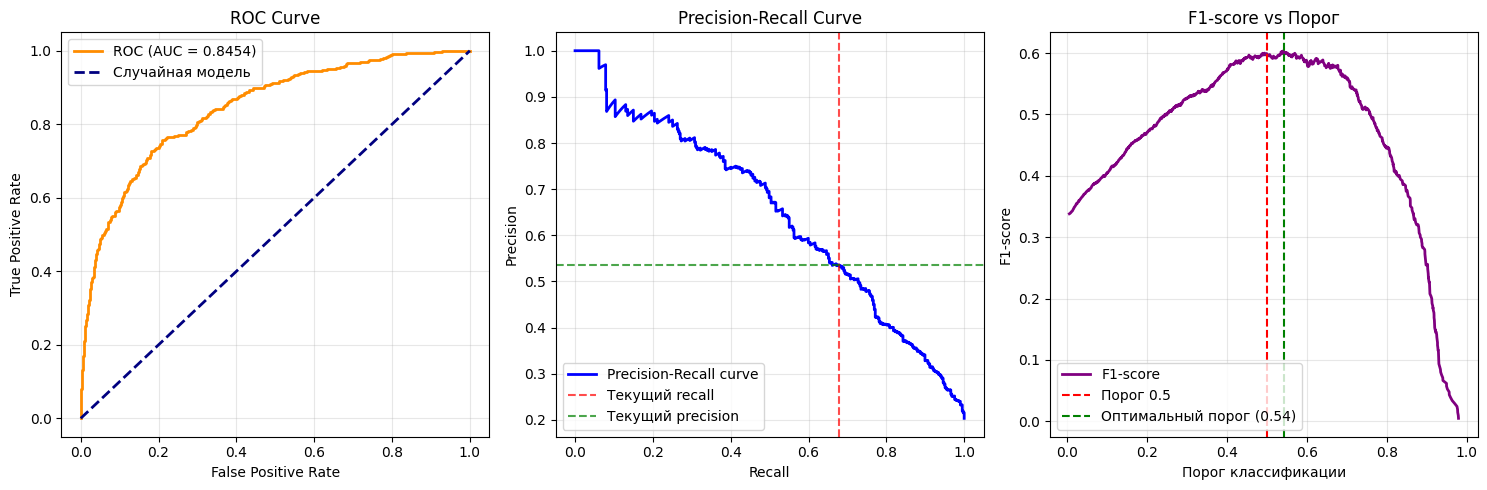

Оптимальный порог для F1: 0.5417
Максимальный возможный F1: 0.6039
Текущий F1 при 0.5: 0.5980


In [ ]:
best_model = final_tuned_models['Random Forest (SMOTE)']['model']
y_test_proba = best_model.predict_proba(X_test_final)[:, 1]

fpr, tpr, thresholds_roc = roc_curve(y_test_final, y_test_proba)
roc_auc = roc_auc_score(y_test_final, y_test_proba)
precision, recall, thresholds_pr = precision_recall_curve(y_test_final, y_test_proba)

f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_idx = np.argmax(f1_scores)
optimal_threshold_pr = thresholds_pr[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайная модель')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.axvline(x=recall_val, color='red', linestyle='--', alpha=0.7, label='Текущий recall')
plt.axhline(y=precision_val, color='green', linestyle='--', alpha=0.7, label='Текущий precision')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(thresholds_pr, f1_scores[:-1], color='purple', lw=2, label='F1-score')
plt.axvline(x=0.5, color='red', linestyle='--', label='Порог 0.5')
plt.axvline(x=optimal_threshold_pr, color='green', linestyle='--', label=f'Оптимальный порог ({optimal_threshold_pr:.2f})')
plt.xlabel('Порог классификации')
plt.ylabel('F1-score')
plt.title('F1-score vs Порог')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Оптимальный порог для F1: {optimal_threshold_pr:.4f}")
print(f"Максимальный возможный F1: {optimal_f1:.4f}")
print(f"Текущий F1 при 0.5: {f1_score_val:.4f}")

---
Рекомендации для банка:

1. Внедрить модель:
   - Использовать Random Forest (SMOTE) для прогнозирования оттока клиентов
   - Обновлять модель ежемесячно на новых данных

2. Удерживать клиентов:
   - Для клиентов с высоким риском оттока (вероятность > 0.7):
     * Персональные предложения
     * Специальные условия

3. Дальнейшее развитие:
   - Сбор дополнительных данных о поведении клиентов
   - Интеграция с CRM-системой
   - Разработка автоматизированной системы удержания
